### Setup

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

import os
import sklearn
import numpy as np
import pandas as pd

## MNIST

In [20]:
def sort_by_target(mnist):
    sorted_train_idx = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[:60000])]))[:, 1]
    sorted_test_idx = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[60000:])]))[:, 1]
    mnist.data[:60000] = mnist.data[sorted_train_idx]
    mnist.target[:60000] = mnist.target[sorted_train_idx]
    mnist.data[60000:] = mnist.data[sorted_test_idx + 60000]
    mnist.target[60000:] = mnist.target[sorted_test_idx + 60000]

In [21]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1, cache=True)

In [23]:
mnist.target = mnist.target.astype(np.int8)
sort_by_target(mnist)

In [24]:
mnist.target

array([0, 0, 0, ..., 9, 9, 9], dtype=int8)

In [28]:
mnist.data.shape

(70000, 784)

In [31]:
X, y = mnist.data, mnist.target
print('X:', X.shape, '\ny:', y.shape)

X: (70000, 784) 
y: (70000,)


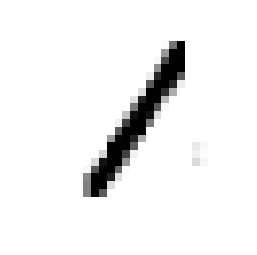

In [37]:
some_digit = X[9999].reshape(28, 28)
plt.imshow(some_digit, cmap=matplotlib.cm.binary)
plt.axis('off')
plt.show()

In [38]:
def plot_digit(data):
    digit = data.reshape(28, 28)
    plt.imshow(digit, cmap=matplotlib.cm.binary, interpolation='nearest')
    plt.show()

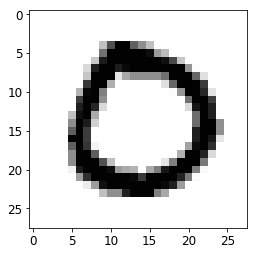

In [39]:
plot_digit(X[22])

In [42]:
def plot_digits(instances, images_per_row=10, **option):
    images_per_row = min(images_per_row, len(instances))
    images = [instance.reshape(28, 28) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((28, 28 * n_empty)))
    row_images = []
    for row in range(n_rows):
        rimages = images[(row * images_per_row): ((row+1) * images_per_row)]
        row_images.append(np.concatenate(rimages, axis=1))
    
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap=matplotlib.cm.binary, interpolation='nearest')
    plt.show   

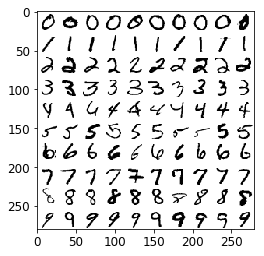

In [45]:
example_images = np.concatenate([X[:12000:600], X[13000:30600:600], X[30600:60000:590]], axis=0)
plot_digits(example_images)

In [46]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [48]:
shuffled_idx = np.random.permutation(len(X_train))
X_train, y_train = X_train[shuffled_idx], y_train[shuffled_idx]

## Binary Classifier
- First, try to classify 5 or Not 5

In [51]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [52]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=5, tol=-np.infty, random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=5,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=42, shuffle=True, tol=-inf,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [64]:
print('Poor performance: ', sgd_clf.predict([X_train[0]]))
y_train_5[0], y_train[0]

Poor performance:  [False]


(True, 5)

In [66]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=5, scoring='accuracy')

array([0.96025331, 0.96825   , 0.96991667, 0.964     , 0.95707976])

In [71]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=5, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = (y_train_5[train_index])
    X_test_fold = X_train[test_index]
    y_test_fold = (y_train_5[test_index])
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))
    

0.9602533122239814
0.96825
0.9699166666666666
0.964
0.9570797566463872


In [76]:
from sklearn.base import BaseEstimator

class Never5Clf(BaseEstimator):
    def __init__(self):
        pass
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [78]:
never_5_clf = Never5Clf()
cross_val_score(never_5_clf, X_train, y_train_5, cv=5, scoring="accuracy")

array([0.90925   , 0.90741667, 0.907     , 0.91333333, 0.91125   ])

In [84]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [85]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[51710,  2869],
       [  912,  4509]], dtype=int64)

In [86]:
y_train_perfect_pred = y_train_5

In [87]:
confusion_matrix(y_train_5, y_train_perfect_pred)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

In [92]:
from sklearn.metrics import precision_score, recall_score

print(precision_score(y_train_5, y_train_pred) == (4509/(4509+2869)))
print(recall_score(y_train_5, y_train_pred) == (4509/(4509+912)))

True
True


In [97]:
y_score = sgd_clf.decision_function([X_train[0]])
y_score, sgd_clf.predict([X_train[0]])

(array([-132731.85331337]), array([False]))

In [98]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method='decision_function')

In [100]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, probas_pred=y_scores)

In [113]:
precisions[:5], recalls[:5], thresholds[:-5:-1], y_scores[:5]

(array([0.09087556, 0.09086032, 0.09086185, 0.09086337, 0.09086489]),
 array([1.        , 0.99981553, 0.99981553, 0.99981553, 0.99981553]),
 array([1264488.80677028, 1207971.11265241, 1111727.00198519,
        1092796.55954518]),
 array([ 501307.29840459, -385069.30048395,  -70948.78247143,
        -566797.31903131, -769569.87013851]))

In [110]:
precisions.shape, recalls.shape, thresholds.shape, y_train_5.shape

((59654,), (59654,), (59653,), (60000,))

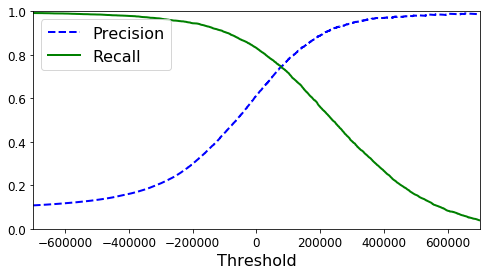

In [102]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.xlabel("Threshold", fontsize=16)
    plt.legend(loc="upper left", fontsize=16)
    plt.ylim([0, 1])

plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.xlim([-700000, 700000])
plt.show()

## ROC curves
Receiver Operating Characteristic curve <br>
plot the TruePositiveRate (recall) against FalsePositiveRate (FPR) <br>
 -- both right-hand side rate on the Row

In [114]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

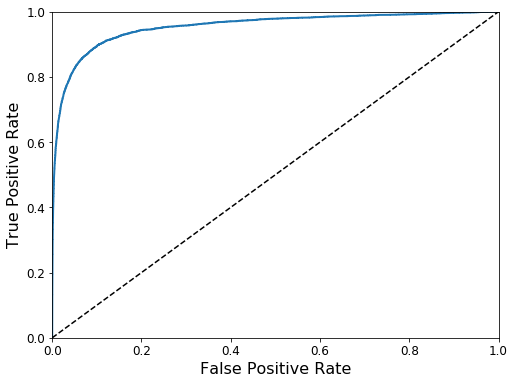

In [115]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)

plt.show()

In [116]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9542940585483235

In [117]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(n_estimators=10, random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")

In [118]:
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

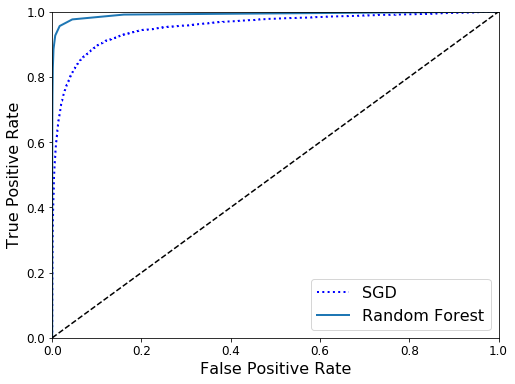

In [119]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right", fontsize=16)
#save_fig("roc_curve_comparison_plot")
plt.show()

# Multiclass classification

In [122]:
# ovo
from sklearn.multiclass import OneVsOneClassifier

ovo_clf = OneVsOneClassifier(SGDClassifier(max_iter=5, tol=-np.infty, random_state=42))
ovo_clf.fit(X_train, y_train)

array([1], dtype=int8)

In [123]:
ovo_clf.predict([some_digit.reshape(-1)])

array([1], dtype=int8)

In [126]:
print('there would be 45 classifiers. 0vs1, 0vs2 ... 8vs9')
len(ovo_clf.estimators_), np.sum(np.arange(10))

there would be 45 classifiers. 0vs1, 0vs2 ... 8vs9


(45, 45)